# From Zero to Hero: Jupyter Notebooks in VS Code


We will go through a notebook demonstrating a common pitfall of ML algorithms.

This demo is intended to help demon

## Generating Data

In [1]:
import numpy as np
import pandas as pd

n_samples = 10_000
rng = np.random.RandomState(32)

experiences = rng.normal(20, 10, size=n_samples).astype(int)
experiences[experiences < 0] = 0

abilities = rng.normal(0, 0.15, size=n_samples)
parent_hourly_wages = 50 * rng.beta(2, 8, size=n_samples)
parent_hourly_wages[parent_hourly_wages < 0] = 0
college_degrees = (
    9 * abilities + 0.02 * parent_hourly_wages + rng.randn(n_samples) > 0.7
).astype(int)

true_coef = pd.Series(
    {
        "college degree": 2.0,
        "ability": 5.0,
        "experience": 0.2,
        "parent hourly wage": 1.0,
    }
)
hourly_wages = (
    true_coef["experience"] * experiences
    + true_coef["parent hourly wage"] * parent_hourly_wages
    + true_coef["college degree"] * college_degrees
    + true_coef["ability"] * abilities
    + rng.normal(0, 1, size=n_samples)
)

hourly_wages[hourly_wages < 0] = 0

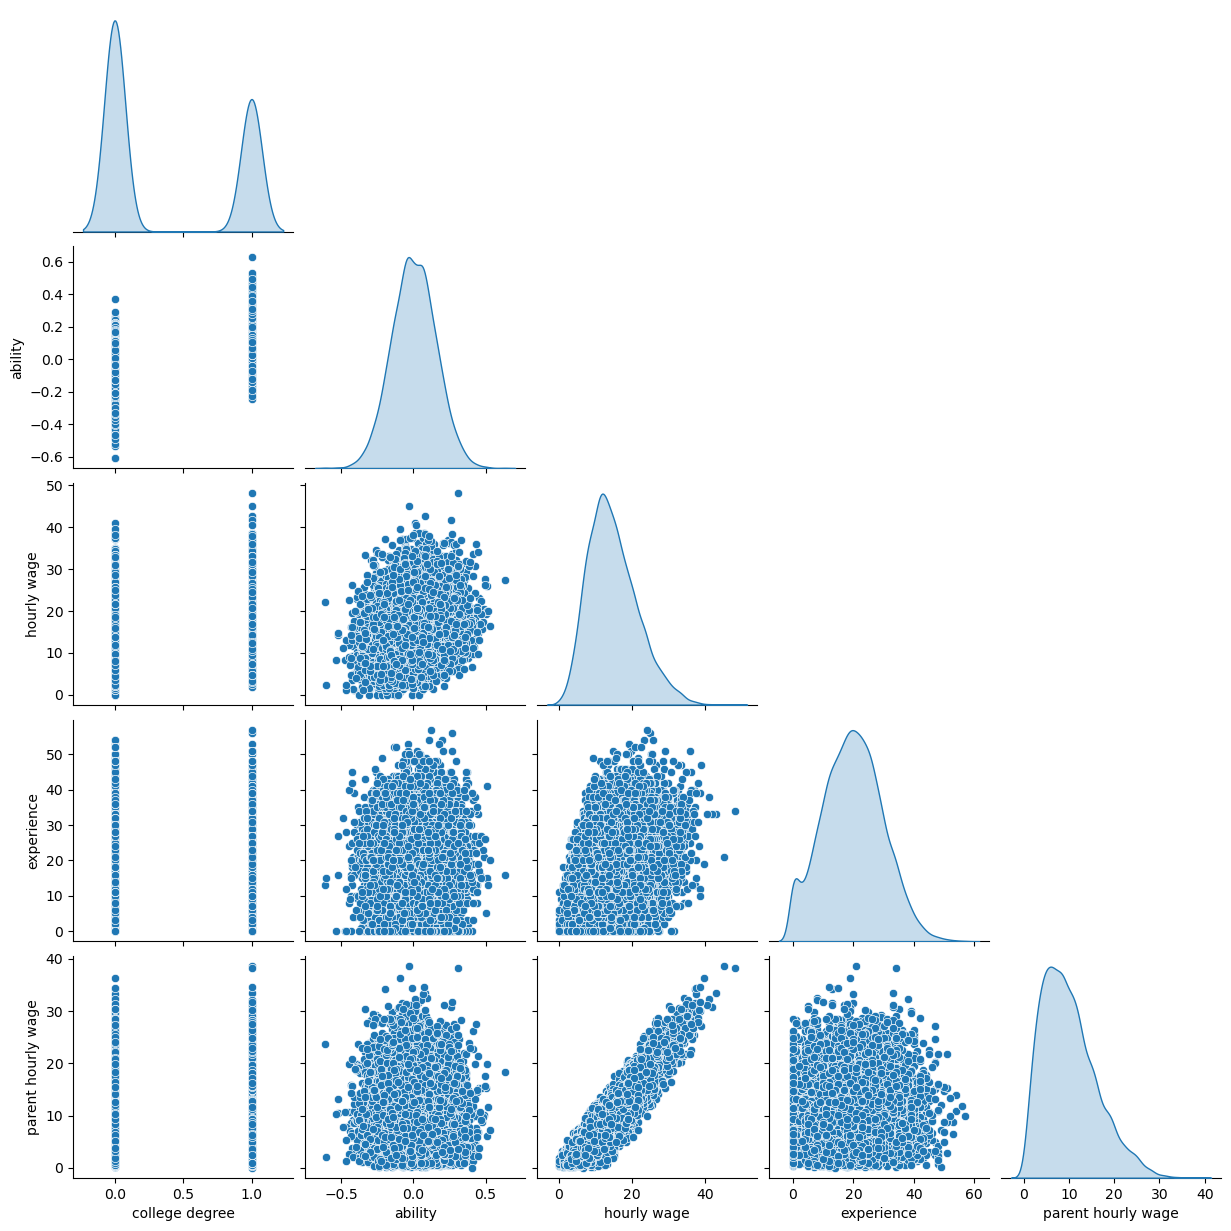

In [2]:
import seaborn as sns

df = pd.DataFrame(
    {
        "college degree": college_degrees,
        "ability": abilities,
        "hourly wage": hourly_wages,
        "experience": experiences,
        "parent hourly wage": parent_hourly_wages,
    }
)

grid = sns.pairplot(df, diag_kind="kde", corner=True)


## Create the training data

In [3]:
from sklearn.model_selection import train_test_split

target_name = "hourly wage"
X, y = df.drop(columns=target_name), df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Run linear regression

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

features_names = ["experience", "parent hourly wage", "college degree", "ability"]

regressor_with_ability = LinearRegression()
regressor_with_ability.fit(X_train[features_names], y_train)
y_pred_with_ability = regressor_with_ability.predict(X_test[features_names])
R2_with_ability = r2_score(y_test, y_pred_with_ability)

print(f"R2 score with ability: {R2_with_ability:.3f}")

R2 score with ability: 0.975


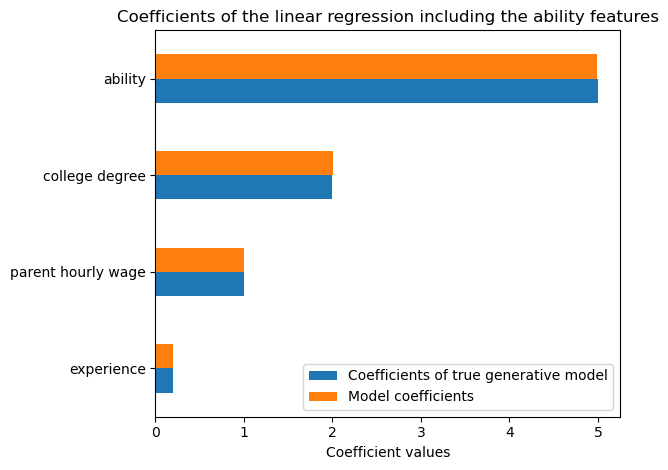

In [5]:
import matplotlib.pyplot as plt

model_coef = pd.Series(regressor_with_ability.coef_, index=features_names)
coef = pd.concat(
    [true_coef[features_names], model_coef],
    keys=["Coefficients of true generative model", "Model coefficients"],
    axis=1,
)
ax = coef.plot.barh()
ax.set_xlabel("Coefficient values")
ax.set_title("Coefficients of the linear regression including the ability features")
_ = plt.tight_layout()

## What if we were missing a parameter?

In [6]:
features_names = ["experience", "parent hourly wage", "college degree"]

regressor_without_ability = LinearRegression()
regressor_without_ability.fit(X_train[features_names], y_train)
y_pred_without_ability = regressor_without_ability.predict(X_test[features_names])
R2_without_ability = r2_score(y_test, y_pred_without_ability)

print(f"R2 score without ability: {R2_without_ability:.3f}")

R2 score without ability: 0.968


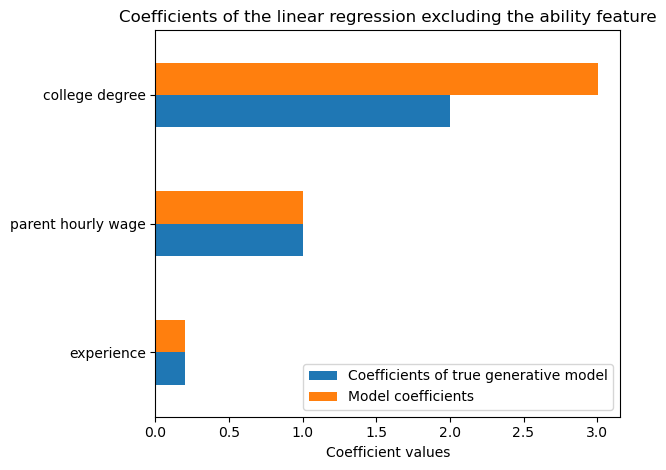

In [7]:
model_coef = pd.Series(regressor_without_ability.coef_, index=features_names)
coef = pd.concat(
    [true_coef[features_names], model_coef],
    keys=["Coefficients of true generative model", "Model coefficients"],
    axis=1,
)
ax = coef.plot.barh()
ax.set_xlabel("Coefficient values")
_ = ax.set_title("Coefficients of the linear regression excluding the ability feature")
plt.tight_layout()
plt.show()